In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
plt.style.use("ggplot")

In [3]:
df = pd.read_csv("FOIA Hopkins 2019 000716 Final.csv")
print(df.shape)
df.head()

C:\Users\zach.goldstein\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(676779, 11)


,Fiscal year,Disaster Number,FEMA Number,Disaster Name,Loan Type,APPROVAL AMOUNT,CITY,STATE,ZIP,COUNTY,STATUS
0,2001,292511,1155.0,CALIF.FLOODING,1,186300,OAKLAND,CA,94619,ALAMEDA,P I F
1,2001,305706,1203.0,CA STORMS/FLOODING,1,60300,LAGUNA NIGUEL,CA,92607,ORANGE,P I F
2,2001,305706,1203.0,CA STORMS/FLOODING,1,77700,GUERNEVILLE,CA,95446,SONOMA,NaN
3,2001,305706,1203.0,CA STORMS/FLOODING,1,200000,MCDONOUGH,GA,30252,SAN MATEO,P I F
4,2001,307412,1212.0,MN TORNADOES,1,22800,LA CROSSE,WI,54603,NICOLLET,NaN


In [4]:
df.dtypes

Fiscal year          int64
Disaster Number     object
FEMA Number        float64
Disaster Name       object
Loan Type            int64
APPROVAL AMOUNT      int64
CITY                object
STATE               object
ZIP                  int64
COUNTY              object
STATUS              object
dtype: object

In [5]:
# Should find out what this means.
df['Loan Type'].value_counts()

1    575854
2    100681
4       244
Name: Loan Type, dtype: int64

In [24]:
df.loc[df['Loan Type']==4,"Loan Type"] = 2

In [6]:
df['STATUS'].value_counts()

P I F     197921
CHGOFF     56242
Name: STATUS, dtype: int64

In [7]:
# Status is usually missing
len(df[df['STATUS'].isna()]) / len(df)

0.6244519998404205

In [8]:
# http://np.news-press.com/data/102
# CHGOFF means "charged off" - meaning government doesn't think it'll be repaid
# PIF I think means "paid in full" but should confirm

In [9]:
# Charged off rate
rows = []
for i, data in df.groupby(by = "FEMA Number"):
    total = len(data)
    chgoffs = len(data[data['STATUS']=="CHGOFF"])
    rows.append([i, total, chgoffs])
df_disaster = pd.DataFrame(rows)
df_disaster.columns = ['FEMA Number','Loans','Charged Off']
df_disaster['Charged Off Rate'] = df_disaster['Charged Off'] / df_disaster['Loans']
df_disaster.head()

,FEMA Number,Loans,Charged Off,Charged Off Rate
0,0.0,10310,579,0.056159
1,1134.0,1,0,0.000000
2,1155.0,1,0,0.000000
3,1203.0,3,0,0.000000
4,1212.0,2,0,0.000000


In [10]:
round(df_disaster['Charged Off Rate'].describe(),3)

count    500.000
mean       0.083
std        0.105
min        0.000
25%        0.031
50%        0.068
75%        0.105
max        1.000
Name: Charged Off Rate, dtype: float64

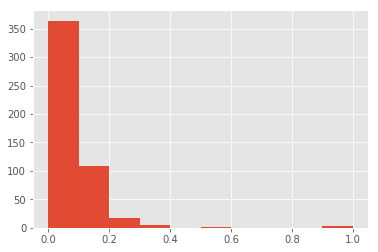

In [11]:
df_disaster['Charged Off Rate'].hist()

In [12]:
df_disaster.sort_values(by = "Charged Off Rate", ascending = False).head(10)

,FEMA Number,Loans,Charged Off,Charged Off Rate
9,1283.0,1,1,1.000000
19,1310.0,1,1,1.000000
16,1299.0,1,1,1.000000
81,1418.0,1,1,1.000000
89,1427.0,152,85,0.559211
23,1327.0,3,1,0.333333
13,1294.0,3,1,0.333333
21,1322.0,3,1,0.333333
162,1527.0,2343,741,0.316261
123,1473.0,231,71,0.307359


In [13]:
rate = df_disaster['Charged Off'].sum() / df_disaster['Loans'].sum()
rate

0.08113468824408503

In [14]:
observed_std = df_disaster['Charged Off Rate'].std()
observed_std

0.10502091127650609

Simulation

In [15]:
random.seed(3169)
def simulate(x, rate = rate):
    charged_offs = 0
    for i in range(x):
        if random.random() < rate:
            charged_offs += 1
    return charged_offs / x

trials = 1000
stds = []
for trial in range(trials):
    simulated_charged_off_rate_std = df_disaster['Loans'].apply(lambda x: simulate(x)).std()
    
    stds.append(simulated_charged_off_rate_std)    
p = len(list(filter(lambda x: x > observed_std, stds))) / trials
p

0.056

In [16]:
# Not statistically significant at the .05 level

Business vs. Home loan charge off rate

In [17]:
df.head()

,Fiscal year,Disaster Number,FEMA Number,Disaster Name,Loan Type,APPROVAL AMOUNT,CITY,STATE,ZIP,COUNTY,STATUS
0,2001,292511,1155.0,CALIF.FLOODING,1,186300,OAKLAND,CA,94619,ALAMEDA,P I F
1,2001,305706,1203.0,CA STORMS/FLOODING,1,60300,LAGUNA NIGUEL,CA,92607,ORANGE,P I F
2,2001,305706,1203.0,CA STORMS/FLOODING,1,77700,GUERNEVILLE,CA,95446,SONOMA,NaN
3,2001,305706,1203.0,CA STORMS/FLOODING,1,200000,MCDONOUGH,GA,30252,SAN MATEO,P I F
4,2001,307412,1212.0,MN TORNADOES,1,22800,LA CROSSE,WI,54603,NICOLLET,NaN


In [20]:
len(df[(df['Loan Type']==1)&(df['STATUS']=="P I F")]) / len(df[(df['Loan Type']==1)&(df['STATUS'].isna()==False)]) 

0.7829545674894806

In [26]:
len(df[(df['Loan Type']==2)&(df['STATUS']=="P I F")]) / len(df[(df['Loan Type']==2)&(df['STATUS'].isna()==False)]) 

0.760458656195827

In [30]:
df.loc[df['STATUS']=="CHGOFF","APPROVAL AMOUNT"].sum()

2363036100

In [40]:
df.dropna(subset = ["STATUS"], axis = 0)['FEMA Number'].value_counts().head()

1603.0    38362
1604.0    17497
1609.0     9329
1379.0     8571
1539.0     7156
Name: FEMA Number, dtype: int64